<center> <img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F450%2F1*CXZ804tKLPy2hiikJbYH3w.png&f=1&nofb=1" width=25% > </center>

<br><br>

<center> 
    <font size="6">Lab 4: Image Alignment, Image Stitching and Panorama Creation</font>
</center>
<center> 
    <font size="4">Computer Vision 1 University of Amsterdam</font> 
</center>
<center> 
    <font size="4">Due 23:59PM, October 4, 2024 (Amsterdam time)</font> 
</center>
<center> 
    <font size="4"><b>TA's: Egoitz & Roan</b></font>
</center>

<br><br>

***

<br><br>

<center>

<font color='yellow'>
Student1 ID: 15813274
<br>
Student1 Name: Matthias Hagenauer
<br><br>
Student2 ID: 13225812
<br>
Student2 Name: Brandon Li
<br><br>
Student3 ID: 13865617
<br>
Student3 Name: Tijs Wiegman
</font>

</center>

### **Import Libraries**

In [2]:
import sys

if sys.version_info[0] < 3:
    raise Exception("Python 3 or a more recent version is required.")

In [3]:
# environment and libraries
import os
import math
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import signal
from matplotlib.patches import ConnectionPatch

In [4]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "4.10.0", "You're not using the provided Python environment!"
assert np.__version__ == "1.26.4", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.9.2", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.

### **Instructions**

Your code and discussion must be handed in this jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Lab 4 Assignment. Please also fill out your names and ID's above.

For full credit, make sure your notebook follows these guidelines:
- It is mandatory to **use the Python environment provided** with the assignment; the environment specifies the package versions that have to be used to prevent the use of particular functions. Using different packages versions may lead to grade deduction. In the Python cell above you can check whether your environment is set up correctly.
- To install the environment with the right package versions, use the following command in your terminal: ```conda env create --file=CV1_environment.yaml```, then activate the environment using the command ```conda activate cv1```.
- Do not use additional packages or materials that have not been provided or explicitly mentioned.
- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions and sub-questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

__Note:__ A more complete overview of the lab requirements can be found in the Course Manual on Canvas

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations. This includes the use of generative tools such as ChatGPT.

**ENSURE THAT YOU SAVE ALL RESULTS / ANSWERS ON THE QUESTIONS (EVEN IF YOU RE-USE SOME CODE).**

### **Overview**

- [Section 1: Image Alignment (55 points)](#section-1)
  - [Question 1 (5 points)](#question-1)
  - [Question 2 (10 points)](#question-2)
  - [Question 3 (15 points)](#question-3)
  - [Question 4 (5 points)](#question-4)
  - [Question 5 (5 points)](#question-5)
  - [Question 6 (3 points)](#question-6)
  - [Question 7 (5 points)](#question-7)
  - [Question 8 (7 points)](#question-8)
  
- [Section 2: Image Stitching (30 points)](#section-2)
  - [Question 9 (20 points)](#question-9)
  - [Question 10 (5 points)](#question-10)
  - [Question 11 (5 points)](#question-11)
  
- [Section 3: Automatic Panorama Stitching (15 points)](#section-3)
  - [Question 12 (15 points)](#question-12)
  
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

<a id="section-1"></a>
### **Section 1: Image Alignment**

In this section, you will develop a function that computes the affine transformation between two images. The goal is to align two supplied images from *Genoa Beach* by following a series of steps that involve detecting interest points, characterizing their local appearances, and matching these regions between the images. This process is fundamental in many computer vision tasks, such as object recognition, image stitching, and motion tracking.

The overall procedure is outlined as follows:

1. **Detect Interest Points:**
   - Identify key points in each image that are likely to be matched between the two images.

2. **Characterize Local Appearance:**
   - Describe the local appearance around each interest point using a region descriptor.

3. **Find Matches:**
   - Match the region descriptors between the two images to identify corresponding points. You can use David Lowe's SIFT (Scale-Invariant Feature Transform) for these steps. SIFT is a powerful method for detecting and describing local features in images. For further information, refer to the [SIFT tutorial](https://docs.opencv.org/3.4.2/da/df5/tutorial_py_sift_intro.html) and the [SIFT class documentation](https://docs.opencv.org/3.4.2/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html).

4. **Perform RANSAC (Random Sample Consensus):**
   - To find the best transformation, perform the following steps:
     - **Repeat N times:**
       - Randomly select a set of P matched pairs from the total set of matches.
       - Construct a matrix A and vector b using the P pairs of points. Solve for the affine transformation parameters \((m1, m2, m3, m4, t1, t2)\) by solving the equation \(Ax = b\). This equation can be solved using the pseudo-inverse \(x = (A^T A)^{-1} A^T b\) or by using Python's Numpy package.
       - Apply the transformation to all matched points in the first image. If the transformation is accurate, the transformed points should lie close to their corresponding points in the second image.
       - Count the number of inliers, where inliers are defined as points from the first image that, when transformed, lie within a radius of 10 pixels from their corresponding points in the second image.
       - If the number of inliers exceeds the best count so far, save the transformation parameters and the set of inliers.

5. **Visualize RANSAC Performance:**
   - Plot the two images side by side and draw lines connecting the original points in the first image with their corresponding transformed points in the second image.

6. **Transform the First Image:**
   - Use the final set of transformation parameters to transform the first image. The transformed image should align with the second image. Implement this transformation using **nearest-neighbor interpolation**. Additionally, use OpenCV's built-in function `cv2.warpAffine` to compare results. Note that nearest-neighbor interpolation involves rounding the coordinates of the transformed points, which is simpler to implement than linear interpolation.


<a id="question-1"></a>
#### <font color='#FF0000'>Question 1 (5 points)</font>

Create a function named **get_matching_keypoints()** that takes two images as input and returns the matching keypoints between them.

The function should use the SIFT (Scale-Invariant Feature Transform) algorithm to detect and describe keypoints in both images. Once the keypoints are detected, use a brute-force matcher with Euclidean distance to find and return the matches between the two images. Make sure to convert the images to grayscale for processing.

The function should return the keypoints detected in the first image, the keypoints detected in the second image, and the matches found between them. Ensure that the function prints the number of keypoints detected in each image, as well as the number of matches found.

To test your function, use the images `genoa_beach.jpg` and `genoa_beach_cut_1.jpg`.

In [5]:
def get_matching_keypoints(image_1, image_2):
    """
    Given two input images, find and return the matching keypoints.

    Args:
        image_1: The first image (in RGB)
        image_2: The second image (in RGB)

    Returns:
        keypoints_image_1: Keypoints detected in the first image
        keypoints_image_2: Keypoints detected in the second image
        matches: Matching keypoints between the two images
    """    
    gray_image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    gray_image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    keypoints_image_1, descriptors_1 = sift.detectAndCompute(gray_image_1, None)
    keypoints_image_2, descriptors_2 = sift.detectAndCompute(gray_image_2, None)

    # crossCheck = True, image A compared to B keypoints needs to be consistent/same as B compared to A keypoints
    # NORM_L2 = Euclidean distance -> is default
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)

    # Output the number of keypoints and matches
    print(f"Number of keypoints in the first image:  {len(keypoints_image_1)}")
    print(f"Number of keypoints in the second image: {len(keypoints_image_2)}")
    print(f"Number of matches: {len(matches)}")

    return keypoints_image_1, keypoints_image_2, matches


In [6]:

image_1 = cv2.imread('./images/genoa_beach.jpg')
image_2 = cv2.imread('./images/genoa_beach_cut_1.jpg')

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

keypoints_image_1, keypoints_image_2, matches = get_matching_keypoints(image_1, image_2)

Number of keypoints in the first image:  14363
Number of keypoints in the second image: 10138
Number of matches: 6248


In [7]:
"""
random_matches = random.sample(matches, 50)

# We only visualize random subset because too many interest points.. 
matched_image = cv2.drawMatches(image_1, keypoints_image_1, image_2, keypoints_image_2, random_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv2.imshow("Matching Keypoints", matched_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

"""
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Display the first image
axes[0].imshow(image_1[:, :, ::-1]) 
axes[0].set_title('Image 1: genoa_beach')
axes[0].axis('off')

axes[1].imshow(image_2[:, :, ::-1]) 
axes[1].set_title('Image 2: genoa_beach_cut_1')
axes[1].axis('off')

random_matches = random.sample(matches, 50)

for match in random_matches:  
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints_image_1[img1_idx].pt
    (x2, y2) = keypoints_image_2[img2_idx].pt

    axes[0].plot(x1, y1, 'ro', markersize=5)
    axes[1].plot(x2, y2, 'ro', markersize=5)

    fig.lines.append(plt.Line2D([x1, x2 + image_1.shape[1]], [y1, y2], color='yellow', lw=0.5))

plt.tight_layout()
plt.show()
"""

"\nfig, axes = plt.subplots(1, 2, figsize=(16, 8))\n\n# Display the first image\naxes[0].imshow(image_1[:, :, ::-1]) \naxes[0].set_title('Image 1: genoa_beach')\naxes[0].axis('off')\n\naxes[1].imshow(image_2[:, :, ::-1]) \naxes[1].set_title('Image 2: genoa_beach_cut_1')\naxes[1].axis('off')\n\nrandom_matches = random.sample(matches, 50)\n\nfor match in random_matches:  \n    img1_idx = match.queryIdx\n    img2_idx = match.trainIdx\n    (x1, y1) = keypoints_image_1[img1_idx].pt\n    (x2, y2) = keypoints_image_2[img2_idx].pt\n\n    axes[0].plot(x1, y1, 'ro', markersize=5)\n    axes[1].plot(x2, y2, 'ro', markersize=5)\n\n    fig.lines.append(plt.Line2D([x1, x2 + image_1.shape[1]], [y1, y2], color='yellow', lw=0.5))\n\nplt.tight_layout()\nplt.show()\n"

<a id="question-2"></a>
#### <font color='#FF0000'>Question 2 (10 points)</font>

Create a function named `draw_random_matches` that takes the matching keypoints found in Question 1, selects a random subset of 10 matching points, and plots them on the images.

The function should connect matching pairs with lines, assigning a random color to each line to make them easier to distinguish. Ensure that the keypoints are marked on both images and that the matching lines are clearly visible. The images should be displayed side by side for easy comparison.

**Hint:** Use `from matplotlib.patches import ConnectionPatch` for drawing the lines between matching keypoints.

In [8]:
def draw_random_matches(image_1, keypoints_1, image_2, keypoints_2, matches, subset_size=10):
    """
    Draw a random subset of matching keypoints between two images.

    Args:
        image_1: The first image (in RGB)
        keypoints_1: Keypoints detected in the first image
        image_2: The second image (in RGB)
        keypoints_2: Keypoints detected in the second image
        matches: Matching keypoints between the two images
        subset_size: Number of random matches to display (default is 10)

    Returns:
        None. The function displays the images with the matching keypoints.
    """

    # YOUR CODE HERE
    random_matches = random.sample(matches, subset_size)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

    
    ax1.imshow(image_1, cmap='gray')
    ax1.set_title('Image 1')
    ax1.axis('off')
    ax2.imshow(image_2, cmap='gray')
    ax2.set_title('Image 2')
    ax2.axis('off')


    for match in random_matches:

        #print(match)
        # print(keypoints_1[2])
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx

        (x1, y1) = keypoints_1[img1_idx].pt
        (x2, y2) = keypoints_2[img2_idx].pt
        color = np.random.rand(3,)

        ax1.plot(x1, y1, 'k*', markersize=15)
        ax2.plot(x2, y2, 'k*', markersize=15)

        con = ConnectionPatch(xyA=(x2, y2), xyB=(x1, y1),
                              coordsA="data", coordsB="data",
                              axesA=ax2, axesB=ax1, linewidth=2, 
                              arrowstyle="<|-|>", 
                              color=color, 
                            #   edgecolor="0", 
                              mutation_scale=30,
                            #   connectionstyle= "angle3"
                             )
        ax2.add_artist(con)

    plt.show()

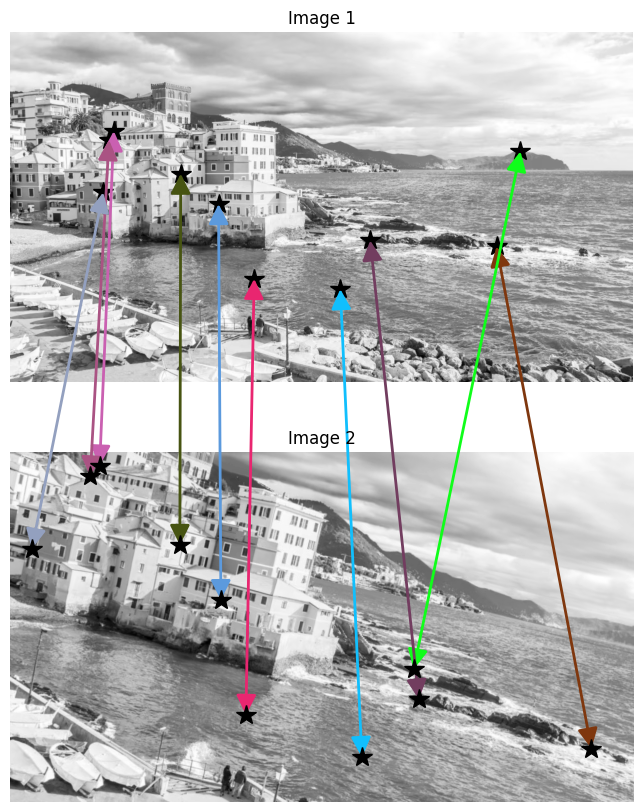

In [9]:
image_1 = cv2.imread('./images/genoa_beach.jpg')
image_2 = cv2.imread('./images/genoa_beach_cut_1.jpg')

gray_image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
gray_image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
draw_random_matches(gray_image_1, keypoints_image_1, gray_image_2, keypoints_image_2, matches, subset_size=10)

<a id="question-3"></a>
#### <font color='#FF0000'>Question 3 (15 points)</font>

In this question, you will implement the RANSAC algorithm to filter out outlier matches between two sets of keypoints by fitting an affine transformation model. You have to complete the following functions:

1. **compute_affine_transformation_matrix:** This function takes a set of point correspondences and computes an affine transformation matrix using those points.
2. **test_affine_transformation_matrix:** This function tests the computed affine transformation matrix on a set of point correspondences and identifies the inliers based on a given threshold.
3. **ransac_algorithm:** This function applies the RANSAC algorithm to find the best affine transformation matrix by repeatedly sampling points and testing the model.

**Note:** You are only allowed to use the Numpy library to implement these functions.

In [10]:
def compute_affine_transformation_matrix(data):
    """
    Compute an affine transformation matrix using a set of point correspondences.

    Args:
        data: An array containing point correspondences between two images.

    Returns:
        transformation_matrix: An affine transformation matrix.
    """
    num_points = len(data)
    A = np.zeros((2 * num_points, 6))
    b = np.zeros((2 * num_points, 1))

    for i in range(num_points):
        # x1, y1, x2, y2 = data[i]
        # A[2 * i] = [x1, y1, 0, 0, 1, 0]
        # b[2 * i] = x2
        # A[2 * i + 1] = [0, 0, x1, y1, 0, 1]
        # b[2 * i + 1] = y2
        
        x1, y1, x2, y2 = data[i]
        A[2 * i] = [x1, y1, 1, 0, 0, 0]
        b[2 * i] = x2
        A[2 * i + 1] = [0, 0, 0, x1, y1, 1]
        b[2 * i + 1] = y2

    params = np.linalg.inv(( A.T @ A )) @ A.T @ b
    transformation_matrix = params.reshape(2,3)
    
    # print(A)
    # params = np.linalg.pinv(A) @ b
    # params = params.flatten()
    # m1, m2, m3, m4, t1, t2 = params

    # transformation_matrix = np.array([
    #     [m1[0], m2[0], m3[0]],
    #     [m4[0], t1[0], t2[0]],
    #     [0, 0, 1]
    # ])

    # transformation_matrix = np.array([
    #     [m1[0], m2[0], t1[0]],
    #     [m3[0], m4[0], t2[0]],
    #     [0, 0, 1]
    # ])

    # transformation_matrix = np.array([
    #     [m1[0], m2[0], t1[0]],
    #     [m3[0], m4[0], t2[0]],
    #     # [0, 0, 1]
    # ])

    return transformation_matrix


In [11]:
def test_affine_transformation_matrix(transformation_matrix, data, threshold=10):
    """
    Test the projective transformation matrix on a set of point correspondences 
    and identify inliers.

    Args:
        transformation_matrix: An affine transformation matrix.
        data: An array containing point correspondences.
        threshold: The distance threshold to consider a transformed point as 
                    an inlier. Default is 10.

    Returns:
        inliers: A list of indices of the inliers within the input data.
    """
    inliers = []

    for i in range(len(data)):
        #print(i)
        x1, y1, x2, y2 = data[i]
        point1 = np.array([x1, y1, 1])
        point1_transformed = transformation_matrix @ point1
        #print(point1_transformed)
        
        transformed_x, transformed_y = point1_transformed[0], point1_transformed[1]
        distance = np.linalg.norm([transformed_x - x2, transformed_y - y2])
        # print(distance)
        
        if distance <= threshold:
            inliers.append(i)

    return inliers

In [12]:
def ransac_algorithm(keypoints_1, keypoints_2, matches, num_iterations, num_points=3, threshold=10):
    """
    Apply the RANSAC algorithm to filter out outlier matches between two sets of 
    keypoints by fitting a projective transformation model.

    Args:
        keypoints_1: The keypoints from the first image.
        keypoints_2: The keypoints from the second image.
        matches: A list of matches between keypoints_1 and keypoints_2.
        num_iterations: The number of iterations for the RANSAC algorithm.
        num_points: The number of points to randomly sample in each iteration 
                    to fit the model. Default is 3.
        threshold: The distance threshold to consider a matched pair as an 
                   inlier. Default is 10.

    Returns:
        best_transformation_matrix: The best transformation matrix found by RANSAC. 
                                    None may be returned if the matrix cannot be computed.
    """
    # YOUR CODE HERE
    
    best_inliers = 0
    best_transformation_matrix = None

    points = []
    for m in matches:
        x1, y1 = keypoints_1[m.queryIdx].pt
        x2, y2 = keypoints_2[m.trainIdx].pt
        points.append([x1, y1, x2, y2])

    points = np.array(points)

    for i in range(num_iterations):
        
        sample_matches = random.sample(points.tolist(), num_points)

        transformation_matrix = compute_affine_transformation_matrix(sample_matches)
        # print(transformation_matrix)
        inliers = test_affine_transformation_matrix(transformation_matrix, points, threshold)

        if len(inliers) > best_inliers:
            best_inliers = len(inliers)
            best_transformation_matrix = transformation_matrix
    
    # Print information
    print("Total number of matches: ", len(matches))
    print("Inliers found:           ", best_inliers)
    print("Outliers removed:        ", len(matches) - best_inliers)

    return best_transformation_matrix, best_inliers

In [14]:
num_iterations = 30
num_points = 3
threshold = 10

# YOUR CODE HERE
image_1 = cv2.imread('./images/genoa_beach.jpg')
image_2 = cv2.imread('./images/genoa_beach_cut_1.jpg')

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

keypoints_image_1, keypoints_image_2, matches = get_matching_keypoints(image_1, image_2)

Number of keypoints in the first image:  14363
Number of keypoints in the second image: 10138
Number of matches: 6248


In [15]:
best_transformation_matrix, best_inliers = ransac_algorithm(keypoints_image_1, keypoints_image_2, matches, num_iterations, num_points, threshold)

# Print the best matrix
print(f'\nBest matrix:\n{best_transformation_matrix}')

Total number of matches:  6248
Inliers found:            5235
Outliers removed:         1013

Best matrix:
[[ 1.11400855e+00 -2.59536389e-01 -4.13581676e+01]
 [ 2.60139602e-01  1.11484030e+00 -3.11779768e+02]]


<a id="question-5"></a>
#### <font color='#FF0000'>Question 4 (5 points)</font>

In this question, you will implement an affine transformation on an image using the transformation matrix obtained from the RANSAC algorithm in the previous question.

Create a function named `apply_affine_transformation` that takes an image and a 2x3 affine transformation matrix as input. The function should perform the affine transformation using either forward or inverse warping, based on the specified method.

Ensure that the transformed image maintains the same dimensions as the input image. The function should handle cases where the transformed coordinates go out of bounds by ignoring those pixels. You can use the resulting transformation matrix from Question 4 as the input for this function.

**Note:** You are only allowed to use the Numpy library to implement this function.

In [271]:
def apply_affine_transformation(image, transformation_matrix, warp_method='forward'):
    """
    Perform an affine transformation on an image.

    Args:
        image: Input image, expected shape (height, width, [channels])
        transformation_matrix: 2x3 affine transformation matrix
        warp_method: Either 'forward' or 'inverse' for the desired warping method. Default is 'forward'.

    Returns:
        transformed_image: Transformed image of the same shape as input
    """
    
    transformation_matrix = np.vstack((best_transformation_matrix, np.array([0,0,1])))
    transformed_image = np.zeros_like(image)
    h,w,channels = np.shape(image)

    if warp_method == 'forward':
        for i in range(w):
            for j in range(h):
                p = np.array([i,j,1])
                p_transformed = transformation_matrix @ p
                i_transformed = round(p_transformed[0])   # Round to nearest pixel
                j_transformed = round(p_transformed[1])   # Round to nearest pixel
                if 0 <= i_transformed < w and 0 <= j_transformed < h:
                    transformed_image[j_transformed,i_transformed] = image[j,i]

    elif warp_method == 'inverse':

        inverse_transformation_matrix = np.linalg.inv(transformation_matrix)
        for i in range(w):
            for j in range(h):
                p = np.array([i,j,1])
                p_transformed = inverse_transformation_matrix @ p
                i_transformed = round(p_transformed[0])   # Round to nearest pixel
                j_transformed = round(p_transformed[1])   # Round to nearest pixel
                if 0 <= i_transformed<w and 0 <= j_transformed<h:
                    # transformed_image[j,i] = image[j_transformed,i_transformed]
                    transformed_image[j_transformed,i_transformed] = image[j,i]
    else:
        raise ValueError("Warp method not defined")

    return transformed_image

<a id="question-6"></a>
#### <font color='#FF0000'>Question 5 (5 points)</font>

Create a function named **visualize_affine_transformations()** that takes the source image, reference image, and the best transformation matrix as inputs, and visualizes the results using four different methods: forward warping, inverse warping, OpenCV’s `warpAffine`, and the original reference image.

The function should display the results in a 2x4 grid of subplots:
- The first row will display the full images transformed by each method.
- The second row will display a zoomed-in section of each transformation for closer inspection.

Ensure that the subplots are well-labeled and that the zoomed-in sections provide a clear view of the differences between the methods.

In [313]:
def visualize_affine_transformations(source_image, reference_image, transformation_matrix):
    """
    Compare different affine transformation methods in a 2x4 grid visualization.

    Args:
        source_image: Source image to transform
        reference_image: Reference image to compare against
        transformation_matrix: Best transformation matrix

    Returns:
        None. Displays a plot without returning a value.
    """

    zoom_factor = 5
    fig, axs = plt.subplots(2, 4, figsize=(20, 8))
    h, w, channels = np.shape(source_image)

    transformed_image = apply_affine_transformation(source_image, transformation_matrix, warp_method='forward')
    inverse_transformed_image = apply_affine_transformation(source_image, transformation_matrix, warp_method='inverse')
    source_image_2 = cv2.warpAffine(source_image, transformation_matrix, (w, h))


    axs[0, 0].imshow(transformed_image)
    axs[0, 0].set_title('Image transform using forward warping')

    axs[0, 1].imshow(inverse_transformed_image)
    axs[0, 1].set_title('Image transform using inverse warpin')

    axs[0, 2].imshow(source_image_2)
    axs[0, 2].set_title('Image transform using warpAffine')

    axs[0, 3].imshow(reference_image)
    axs[0, 3].set_title('Reference Image')

    h,w,channels = np.shape(source_image)
    crop_h = h // zoom_factor
    crop_w = w // zoom_factor
    center_h, center_w = h // 2, w // 2

    source_image_zoom = source_image_2[center_h - crop_h//2:center_h + crop_h//2, center_w - crop_w//2:center_w + crop_w//2]
    transformed_image_zoom = transformed_image[center_h - crop_h//2:center_h + crop_h//2, center_w - crop_w//2:center_w + crop_w//2]
    inverse_transformed_image_zoom = inverse_transformed_image[center_h - crop_h//2:center_h + crop_h//2, center_w - crop_w//2:center_w + crop_w//2]
    reference_image_zoom = reference_image[center_h - crop_h//2:center_h + crop_h//2, center_w - crop_w//2:center_w + crop_w//2]

    # Zoomed
    axs[1, 0].imshow(transformed_image_zoom)
    axs[1, 0].set_title('Zoomed transform using forward warping')

    axs[1, 1].imshow(inverse_transformed_image_zoom)
    axs[1, 1].set_title('Zoomed transform using inverse warping')

    axs[1, 2].imshow(source_image_zoom)
    axs[1, 2].set_title('Zoomed transform using warpAffine')

    axs[1, 3].imshow(reference_image_zoom)
    axs[1, 3].set_title('Zoomed Reference Image')

    for ax in axs.flat:
        ax.axis('off')
    

Number of keypoints in the first image:  14365
Number of keypoints in the second image: 10137
Number of matches: 6248
Total matches:  6248
Inliers:        5236
Outliers:       1012


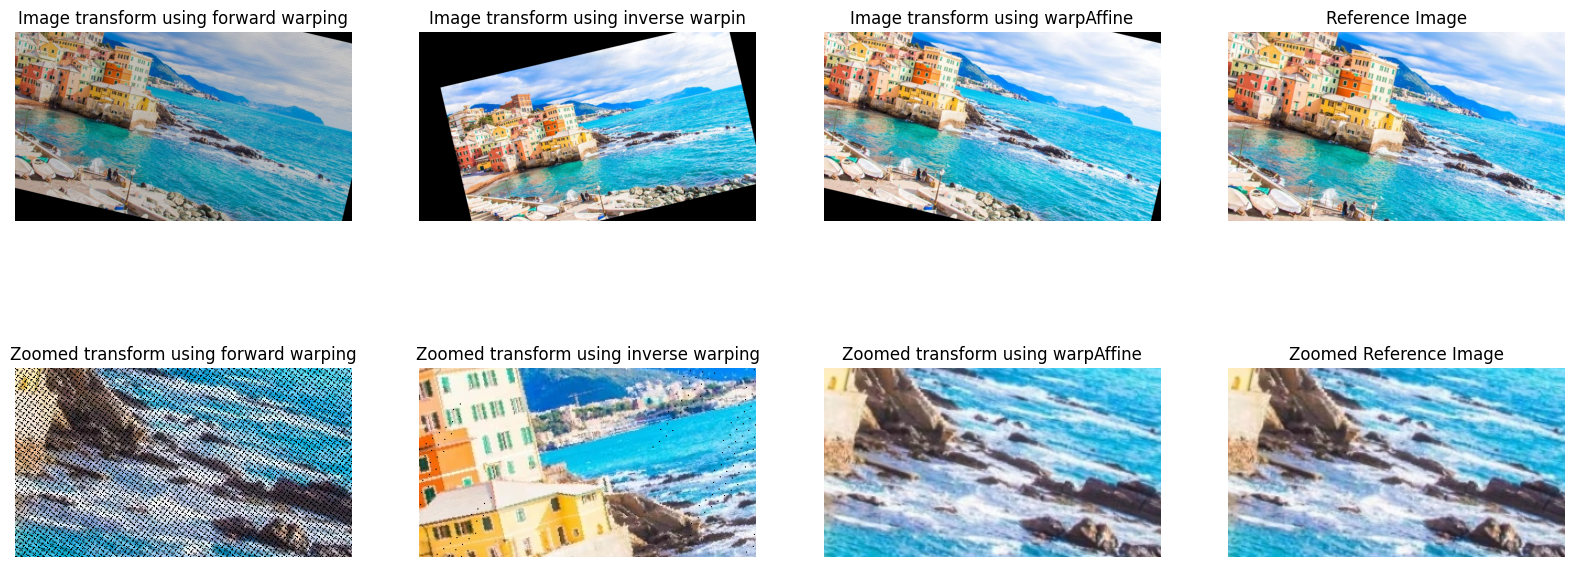

In [314]:
num_iterations = 30
num_points = 3
threshold = 10

image_1 = cv2.imread('./images/genoa_beach.jpg')
image_2 = cv2.imread('./images/genoa_beach_cut_1.jpg')

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

source_image = image_1
reference_image = image_2

keypoints_image_1, keypoints_image_2, matches = get_matching_keypoints(image_1, image_2)
best_transformation_matrix,best_inliers = ransac_algorithm(keypoints_image_1, keypoints_image_2, matches, num_iterations, num_points, threshold)
visualize_affine_transformations(source_image, reference_image, best_transformation_matrix)



<a id="question-6"></a>
#### <font color='#FF0000'>Question 6 (3 points)</font>

How many matches are required to solve an affine transformation formulated as follows:

$
\begin{bmatrix}
x'\\y'
\end{bmatrix} =
\begin{bmatrix}
m_1 & m_2\\
m_3 & m_4
\end{bmatrix}
\begin{bmatrix}
x\\y
\end{bmatrix} +
\begin{bmatrix}
t_1\\t_2
\end{bmatrix}
$

This equation can be rewritten as:

$
\begin{bmatrix}
x&y&0&0&1&0\\
0&0&x&y&0&1
\end{bmatrix}
\begin{bmatrix}
m_1\\
m_2\\
m_3\\
m_4\\
t_1\\
t_2
\end{bmatrix} =
\begin{bmatrix}
x'\\y'
\end{bmatrix}
$

Alternatively:

$
Ax = b, \;
A = \begin{bmatrix}
x&y&0&0&1&0\\
0&0&x&y&0&1
\end{bmatrix}, \;
x = \begin{bmatrix}
m_1\\
m_2\\
m_3\\
m_4\\
t_1\\
t_2
\end{bmatrix}, \;
b = \begin{bmatrix}
x'\\y'
\end{bmatrix}
$

##### <font color='yellow'>Answer:</font>

> Your answer here.

Minimal 1 match is required to solve an affine transformation, since solving the Least Squares results in A.T @ A = 6x2 @ 2x6 = 6x6, so the dimensions will fit for 1 match and also larger than 1

<a id="question-7"></a>
#### <font color='#FF0000'>Question 7 (5 points)</font>

What happens if we have more point matches than the minimum required for solving an affine transformation? Will the code still work, and why?

##### <font color='yellow'>Answer:</font>

> Your answer here.

Yes, it will work, since Least Squares dimensionality will fix it

<a id="question-8"></a>
#### <font color='#FF0000'>Question 8 (7 points)</font>

How many iterations are required in RANSAC to reliably find the correct transformation parameters? Provide a detailed explanation, and use mulitple figures to support your answer.

##### <font color='yellow'>Answer:</font>

> Your answer here.

k= 
log(1−w n) /
log(1−p)
​


In [17]:
# YOUR CODE HERE

<a id="section-2"></a>
### **Section 2: Image Stitching**

In this section, we will explore the process of image stitching, a technique used to combine multiple images into a single, seamless panorama. This process involves aligning and blending overlapping images to create a larger, cohesive image. By determining the geometric transformation needed to align one image with another, we can map the images to a common coordinate system. Image stitching is widely used in various applications, including photography, computer vision, and virtual reality, where creating wide-angle or high-resolution images from multiple photos is essential.

<a id="question-9"></a>
#### <font color='#FF0000'>Question 9 (20 points)</font>

Create a function named **stitch_images_together()** that takes a pair of images as input and returns the stitched result. 

The function should:
- Find the best transformation between the input images using the RANSAC algorithm.
- Estimate the size of the stitched image.
- Transform one image into the coordinate space of the other.
- Combine the transformed image with the other to create a seamless panorama.

Ensure that the function correctly handles both directions—transforming the first image to the coordinate space of the second, and vice versa. The final output should be well-stitched and padded rather than cropped.

**Note:** You can use the `cv2.warpAffine` function to apply the transformation to the images. But you should implement the stitching process yourself **without** using any built-in stitching functions from OpenCV.

Number of keypoints in the first image:  14365
Number of keypoints in the second image: 10137
Number of matches: 6248
Total matches:  6248
Inliers:        5236
Outliers:       1012


(array([[[197, 155, 136],
         [201, 159, 139],
         [203, 161, 142],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[224, 184, 164],
         [219, 180, 160],
         [215, 175, 155],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[243, 206, 187],
         [242, 204, 186],
         [242, 204, 184],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
  

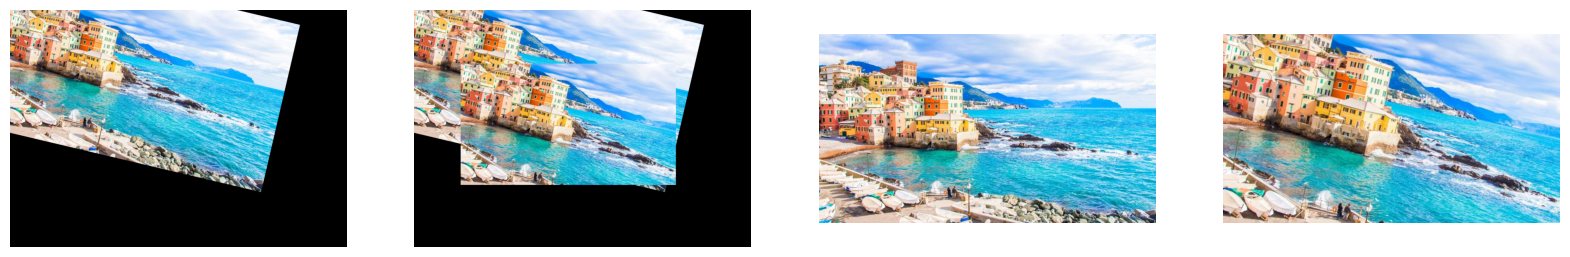

In [315]:
def stitch_images_together(image_1, image_2, transformation_matrix):
    """
    Given two input images, stitch image_1 onto image_2.

    Args:
        image_1: The first image (in RGB).
        image_2: The second image (in RGB).
        transformation_matrix: Transformation matrix for image_1 to match image_2

    Returns:
        output_image: The stitched image combining the two input images.
        offset_image_2: Offset of image_2 in the new output image coordinate system.
    """

    # Plan: priority to image 2, stitch image 1 onto it
    # Find where corners of image 1 end up
    # Use the max of corners of 2 and transformed corners of 1 and create 0s array
    # Fill with transformed image 1
    # Translate image 2 around so it has the correct place in the new bounding box
    # Fill with image 2 (overrule transformed image 1 as image 2 is less distoreted)
    # Results is a stitched image

    h1,w1,channels = np.shape(image_1)
    h2,w2,channels = np.shape(image_2)
    
    keypoints_image_1, keypoints_image_2, matches = get_matching_keypoints(image_1, image_2)
    best_transformation_matrix,best_inliers = ransac_algorithm(keypoints_image_1, keypoints_image_2, matches, num_iterations=30, num_points=3, threshold=10)
    best_transformation_matrix = best_transformation_matrix[:2,:]

    corners_image_1 = np.array([[0,0,1],[w1,0,1],[w1,h1,1],[0,h1,1]],dtype='float32')     # Bottom Left, Bottom Right, Top Rigth, Top Left
    corners_transformed_image = np.array([best_transformation_matrix @ corners_image_1[i] for i in range(4)])

    x_min = int(np.floor(min(0, corners_transformed_image[0][0],corners_transformed_image[1][0],corners_transformed_image[2][0],corners_transformed_image[3][0])))
    x_max = int(np.ceil(max(w2, corners_transformed_image[0][0],corners_transformed_image[1][0],corners_transformed_image[2][0],corners_transformed_image[3][0])))
    y_min = int(np.floor(min(0, corners_transformed_image[0][1],corners_transformed_image[1][1],corners_transformed_image[2][1],corners_transformed_image[3][1])))
    y_max = int(np.ceil(max(h2, corners_transformed_image[0][1],corners_transformed_image[1][1],corners_transformed_image[2][1],corners_transformed_image[3][1])))

    w_stitched = x_max - x_min + 1
    h_stitched = y_max - y_min + 1

    transformed_image_1 = cv2.warpAffine(image_1,best_transformation_matrix, (w_stitched,h_stitched))

    offset_x = 0
    offset_y = 0

    if x_min < 0:
        offset_x = -x_min
    if y_min < 0:
        offset_y = -y_min
    offset_image_2 = (offset_x, offset_y)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    output_image = np.zeros((h_stitched,w_stitched,3),dtype=np.uint8)
    output_image = np.maximum(output_image, transformed_image_1)
    axs[0].imshow(output_image)

    output_image[offset_y:offset_y + h2, offset_x:offset_x + w2] = image_2


    axs[1].imshow(output_image)
    axs[2].imshow(image_1)
    axs[3].imshow(image_2)

    for ax in axs.flat:
        ax.axis('off')

    return output_image, offset_image_2

stitch_images_together(image_1, image_2, transformation_matrix=1)

<a id="question-10"></a>
#### <font color='#FF0000'>Question 10 (5 points)</font>

Write code to load the images `genoa_beach_cut_2.jpg` and `genoa_beach_cut_3.jpg`, stitch them together, and visualize the results. First, stitch `genoa_beach_cut_2.jpg` onto `genoa_beach_cut_3.jpg`, then perform the reverse operation by stitching `genoa_beach_cut_3.jpg` onto `genoa_beach_cut_2.jpg`. Visualize both original images and the resulting stitched images.

In [19]:
# YOUR CODE HERE

<a id="question-11"></a>
#### <font color='#FF0000'>Question 11 (5 points)</font>

Now, write code to load the images `sciencepark_1.jpg` and `sciencepark_2.jpg`, stitch them together, and visualize the results. First, stitch `sciencepark_1.jpg` onto `sciencepark_2.jpg`, then perform the reverse operation by stitching `sciencepark_2.jpg` onto `sciencepark_1.jpg`. Visualize both original images and the resulting stitched images.

In [20]:
# YOUR CODE HERE

<a id="section-3"></a>
### **Section 3: Automatic Panorama Stitching**

In this section, you will create a panorama by stitching together multiple images. The goal is to combine a series of images into a single, wide-angle view that captures the entire scene seamlessly. This process involves detecting features in each image, matching these features between consecutive images, and computing the geometric transformations needed to align and blend them into a cohesive panorama. By mapping the images to a common coordinate system using these transformations, you can effectively stitch them together into one continuous view.

<a id="question-12"></a>
#### <font color='#FF0000'>Question 12 (15 points)</font>

Create a function named **`automatic_panorama_stitching(images, use_mask=True)`** that stitches a series of images together to create a panorama. The function should accept a list of input images and manually implement the stitching process using feature detection and matching techniques. This includes performing feature matching between images, estimating the homography between matched features, and warping images to align them into a panorama.

The function should handle cases where stitching fails, providing appropriate error messages if necessary. After stitching, and based on the **`use_mask`** parameter, the function should crop the stitched image using the bounding rectangle to remove unnecessary areas, such as black borders.

Apply your function on the image paths provided below and visualize the results for each set of images. Make sure to **also** visualize the difference between **`use_mask`** set to **True** and **False**.

```python
image_paths = [
    'panorama_images/panorama_cut_1.jpg',
    'panorama_images/panorama_cut_2.jpg',
    'panorama_images/panorama_cut_3.jpg',
    'panorama_images/panorama_cut_4.jpg',
]

image_paths = [
    'panorama_images/panorama_2_cut_1.jpg',
    'panorama_images/panorama_2_cut_2.jpg',
    'panorama_images/panorama_2_cut_3.jpg',
    'panorama_images/panorama_2_cut_4.jpg',
    'panorama_images/panorama_2_cut_5.jpg',
    'panorama_images/panorama_2_cut_6.jpg',
    'panorama_images/panorama_2_cut_7.jpg',
    'panorama_images/panorama_2_cut_8.jpg',
]
```

**Note:** You are allowed to use any of the functions you have implemented in the previous sections, but you are also allowed to use any other functions from OpenCV.

In [21]:
def automatic_panorama_stitching(images, use_mask=True):
    """
    Automatically stitch a series of images together to create a panorama.

    Args:
        images: A list of input images to stitch together.
        use_mask: A boolean indicating whether to use a mask for the final stitched image. (default is True)

    Returns:
        stitched: The final stitched image.
    """

    # YOUR CODE HERE

    return stitched

In [22]:
# YOUR CODE HERE

In [23]:
# YOUR CODE HERE

<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name | Contribution on Research | Contribution on Programming | Contribution on Writing |
| -------- | ------- | ------- | ------- |
| Brandon | 33 % | 33 % | 33 % |
| Tijs| 33 % | 33 % | 33 % |
| Matthias | 33 % |33 % |33 % |
|  | - % | - % | - % |

### - End of Notebook -